# Analysis of Bubble Tea Shops in the DMV (D.C., Maryland, Virginia)

### By Jason Chen

### CMSC 320 Final Tutorial

## Project Outline

1. [Introduction](#1.-Introduction)
    * A. Background
    * B. Libraries Used
2. [Data Collection](#2.-Data-Collection)
    * A. About the Dataset
    * B. Retrieving the Dataset
3. [Data Cleaning](#3.-Data-Cleaning)
4. [Data Visualization and Analysis](#4.-Data-Visualization-and-Analysis)
5. [Conclusion](#5.-Conclusion)
    * A. Recap
    * B. Final Thoughts

## 1. Introduction

### 1A. Background

[Bubble tea](https://en.wikipedia.org/wiki/Bubble_tea) (also known as boba) is a Taiwanese tea-based drink invented in the 1980s. It most commonly consists of tea and comes with tapioca balls (bubbles) as toppings, but other toppings can be used as well such as coconut jelly, grass jelly, and red bean. Each Bubble tea shop has their own unique drinks as well as common ones. Some shops are known for their toppings such as cheese foam or brown sugar bubbles. 

The United States has recently witnessed a significant growth of the bubble tea market over the years. According to Google Trends, the popularity of Bubble tea in the United States has grown exponentially in the last few years. 

In this tutorial, we will observe and analyze the potential trends of Bubble tea shops in the DMV. We can then use what we learn to find out the best places to visit for Bubble tea while in the DMV.

### 1B. Libraries Used
1. requests 
2. pandas
3. matplotlib
4. seaborn
5. folium
6. re

In [32]:
import requests
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import re

## 2. Data Collection

### 2A. About the Dataset
The dataset used in my analysis is retrieved using the Yelp Fusion API. Using the API, I searched all boba/bubble tea shops within the DMV area (Washing D.C., Maryland, Virginia). I used the API's /businesses/search endpoint to get information about the business. The endpoint returns a json body that contains the business name, rating, price, review count, location, contact, and miscellaneous information. 
Yelp's Fusion API allows many different parameters when calling the /businesses/search endpoint but for the analysis we only need to focus on limit, location, term, categories, and offset. 

Parameters: 
* limit, offset - used to iterate over all the businesses returned by the API call.
* location - used to filter bubble tea shops only in the DMV location.
* term, categories - used to filter searches to only those categorized as bubble tea shops.

In order to access and use the Yelp Fusion API, you need to create an app with Yelp to obtain an API key. To create one, follow the steps [here](https://www.yelp.com/developers/documentation/v3/authentication). 

Note that since we are requesting data from the API, your data and analysis may differ slightly depending on when you run this tutorial as the Yelp Fusion API updates every month. The data and analysis from this tutorial are from May 16th, 2022.

In [33]:
api_key = '' # Enter your API key
def get_businesses(location, api_key):
  headers = {'Authorization': 'Bearer %s' % api_key}
  url = 'https://api.yelp.com/v3/businesses/search'
  data = []
  for offset in range(0, 1000, 50):
    params = {
        'limit': 50, 
        'location': location,
        'term' : 'bubble tea',
        'categories' : 'bubbletea, boba',
        'offset': offset
    }

    r = requests.get(url, headers=headers, params=params)
    if r.status_code == 200:
        data += r.json()['businesses']
    elif r.status_code == 400:
      print('400 Bad Request')
      break

  return data

### 2B. Retrieving the Dataset

First, we will call our function to request data from the API.

In [34]:
data = get_businesses("MD, Maryland, VA, Virginia, DC, Washington DC", api_key)

Next, we will put the data received from the API into a pandas dataframe for easier manipulation for our analysis later. 

In [35]:
df = pd.DataFrame(data)

## 3. Data Cleaning

The API returns several categories, some of which are not needed for the analysis so we will drop those. 
The ones we will keep in our dataframe are:
* name - name of business
* review_count - number of reviews for business
* rating - average rating for business
* coordinates - latitude and logitude of business
* price - approximate cost per person

Yelp uses dollar signs (\$) to categorize approximate cost per person for a meal in a shop. 
In particular, "\$" means under \$10; "\$\$" means "\$11-\$30"; "\$\$\$" means "\$31-\$60"; and "\$\$\$\$" means "above \$61". 

* location - address of business

Categories such as coordinates and location are in the form of a json so we will seperate them into their own columns and drop any that are not needed.
The ones we will keep in our dataframe are:
* latitude
* longitude
* city 
* state

In [36]:
# Filter by shops that are open only
df = df[df['is_closed'] == False]

In [37]:
# Drop columns that are not needed
df.drop(['alias', 'id', 'is_closed', 'image_url', 'url', 'categories', 'transactions', 'distance', 'phone', 'display_phone'], axis=1, inplace=True)

# Separate json into their own columns
df_lat_lon = pd.json_normalize(df['coordinates'])
df_city_state = pd.json_normalize(df['location'])

# Drop columnms that are not needed
df_city_state.drop(['address1', 'address2', 'address3', 'zip_code','country', 'display_address'], axis=1, inplace=True)
df = pd.concat([df, df_lat_lon, df_city_state], axis=1, join='inner')

# Drop columnms that are not needed
df.drop(['coordinates', 'location'], axis=1, inplace=True)
df

,name,review_count,rating,price,latitude,longitude,city,state
0,Tan-Cha,98,4.5,$$,38.813181,-77.183969,Annandale,VA
1,BoBaPoP Tea Bar - Merrifield,97,4.5,$$,38.873687,-77.226773,Falls Church,VA
2,Bubble Mochi,33,4.5,$$,38.900420,-77.267140,Vienna,VA
3,Cafe Miki,91,4.5,NaN,38.635102,-77.296592,Woodbridge,VA
4,Heo Tea,66,4.5,$$,38.836180,-77.434548,Centreville,VA
...,...,...,...,...,...,...,...,...
237,Tutti Frutti Frozen Yogurt,90,3.5,$,39.049637,-77.115531,North Bethesda,MD
238,Kokee Tea at Arundel Mills Mall,1,4.0,NaN,39.157807,-76.724818,Hanover,MD
239,Asian Bakery Cafe,203,3.5,$,39.093413,-77.152965,Rockville,MD
240,Tea.com,1,2.0,NaN,39.152634,-77.206482,Gaithersburg,MD


Now that we have our data in a dataframe and all the columns we want, we can start cleaning up some of the data. 

Bubble tea shops are often part of a franchise so they would share the same name. We will use the name in our analysis later so we have to make sure all franchises have the same name inside the dataframe as the data from the API may differ. There could be misspellings or added symbolsl to the name so we will have to fix that.
In our current data there are some names separates by a ' - ' with their location behind the shop name. We want to only keep the shop name and remove the ' - ' and anything after it so shops that are part of the same franchise will have the same name when analyzing. For example "Gong Cha - North Bethesda" is part of the Gong Cha Bubble tea franchise but has a different name since it has an added location.
These are some of the differing shop names.

In [38]:
name_counts = df['name'].value_counts().reset_index()
name_counts = name_counts.rename(columns={'index':'name', 'name':'count'})
name_counts[name_counts['name'].str.contains(' - ')]

,name,count
30,Den Da Coffee - Towson,1
48,Jumbo Jumbo Cafe - Germantown,1
52,Kung Fu Tea - Ellicott City,1
55,Gong Cha - North Bethesda,1
60,Class 520 - Rockville,1
78,Java Loco - Falls Church,1
96,Kokee Tea - Annapolis,1
126,Ben Gong’s Tea - Annandale,1
137,BoBaPoP Tea Bar - Kentlands,1
138,Supreme Barbeque - AunTea Boba,1


Next, we will remove clean up those names and also check for any white spaces and mispellings of shop names by adding a common name (no white space, all lower case) to all shops. 

In [39]:
format_names = []
for row in range(len(name_counts)):
    n = re.split(r'( \- )', name_counts['name'][row])[0].replace(' ', '').lower()
    format_names.append(n)  

name_counts = pd.concat([name_counts, pd.Series(format_names).rename('common_name')], axis=1)
name_counts

,name,count,common_name
0,Kung Fu Tea,28,kungfutea
1,Gong Cha,15,gongcha
2,Kokee Tea,6,kokeetea
3,Panda Tea House,3,pandateahouse
4,Tea Mansion,3,teamansion
...,...,...,...
176,Donutchew - Fair Oaks Mall,1,donutchew
177,Utepia Tea,1,utepiatea
178,Teaism - Penn Quarter,1,teaism
179,Koi Tea,1,koitea


Now that each shop has their corresponding common name, we can check duplicate entries to find differing names for shops under the same franchise.

In [40]:
# List of duplicate names to be combined
is_duplicate = name_counts['common_name'].value_counts() > 1
duplicate_names = (is_duplicate.loc[is_duplicate].index).to_list()

duplicate_names

['kokeetea',
 'bobapopteabar',
 'javaloco',
 "bengong'stea",
 'kungfutea',
 'class520',
 'jumbojumbocafe',
 'mr.wish',
 'sharetea',
 'gongcha',
 'vivibubbletea',
 'tigersugar']

In [41]:
name_counts = (name_counts.loc[name_counts['common_name'].isin(duplicate_names)]
                .sort_values(by='common_name'))

# Formatted names (lowercase & removed white space) back to shop names and any addition names to be hard coded ex. Names with city added to the end without separator
new_names = {
            'kokeetea' : 'Kokee Tea',
            'bobapopteabar' : 'BoBaPoP Tea Bar',
            'javaloco' : 'Java Loco',
            'kungfutea' : 'Kung Fu Tea',
            'mr.wish' : 'Mr. Wish',
            'tigersugar' : 'Tiger Sugar',
            'class520' : 'Class 520',
            'sharetea' : 'Share Tea',
            'vivibubbletea' : 'Vivi Bubble Tea',
            'jumbojumbocafe' : 'Jumbo Jumbo Cafe',
            "bengong'stea" : "Ben Gongs Teas",
            'gongcha' : 'Gong Cha'
            }

name_counts['common_name'] = name_counts['common_name'].replace(new_names)
name_counts

,name,count,common_name
155,Ben Gong's Tea - Fairfax,1,Ben Gongs Teas
6,Ben Gong's Tea,2,Ben Gongs Teas
42,Bengong's Tea,1,Ben Gongs Teas
137,BoBaPoP Tea Bar - Kentlands,1,BoBaPoP Tea Bar
154,BoBaPoP Tea Bar - Merrifield,1,BoBaPoP Tea Bar
140,BobaPop Tea Bar - Germantown,1,BoBaPoP Tea Bar
60,Class 520 - Rockville,1,Class 520
36,Class 520,1,Class 520
55,Gong Cha - North Bethesda,1,Gong Cha
1,Gong Cha,15,Gong Cha


We will replace the misspeled names with their correct franchise names. 
Some shop names were not caught when doing our inital cleaning. These names have extra words, special characters, or locations that can't be easily filtered so we will have to manually convert them.

In [42]:
# Dictionary of old names and correct shop names
replace_duplicates = dict(zip(name_counts['name'], name_counts['common_name']))
# Combine same bubble tea shop with different names into correct shop name
df['name'] = df['name'].replace(replace_duplicates)

extra_names = {
    'Ben Gong’s Tea - Annandale' : 'Ben Gongs Teas',
    'Kung Fu Tea II' : 'Kung Fu Tea',
    'Kokee Tea at Arundel Mills Mall' : 'Kokee Tea',
    'Gong Cha Arundel Mills' : 'Gong Cha',
    'Gong Cha Chantilly' : 'Gong Cha',
    'Gong Cha Springfield' : 'Gong Cha',
    'Gongcha Arlington' : 'Gong Cha',
    'Gong Cha & Fuji Teriyaki Grill' : 'Gong Cha',
    'Tea-Do Ellicott City' : 'Tea-Do',
    'Chatime Federal Hill' : 'Chatime',
    'ChaTime White Marsh' : 'Chatime',
    'Jumbo Jumbo Cafe Asia Taste' : 'Jumbo Jumbo Cafe',
    "Jasmine's Smoothie World" : 'Jasmine Smoothie World And Bubble Tea',
    'Donutchew - Fair Oaks Mall' : 'Donutchew',
    'Donutchew Annandale' : 'Donutchew',
    'Mr Wish' : 'Mr. Wish',
    'Moge Tee Tysons Corner' : 'Moge Tee',
    'Moge Tee Rockville' : 'Moge Tee',
    'Moge Tee DC' : 'Moge Tee'
}
df['name'] = df['name'].replace(extra_names)

Let's display the counts of the bubble tea shops again. We see that the franchise shops such as Kung Fu Tea and Gong Cha have increased showing that we successfully fixed the names of those shops. 

In [43]:
df['name'].value_counts()

Kung Fu Tea              30
Gong Cha                 21
Kokee Tea                 9
Ben Gongs Teas            5
Moge Tee                  4
                         ..
The Empress Pearl Tea     1
TBaar                     1
Spot of Tea - 14th St     1
520 Ice Cream and Tea     1
Panda Express             1
Name: name, Length: 148, dtype: int64

We are finally done cleaning our data!

Now we can start creating visualizations and analyze the data.

## 4. Data Visualization and Analysis

After parsing and cleaning, our dataframe now looks like this. 

In [44]:
df

,name,review_count,rating,price,latitude,longitude,city,state
0,Tan-Cha,98,4.5,$$,38.813181,-77.183969,Annandale,VA
1,BoBaPoP Tea Bar,97,4.5,$$,38.873687,-77.226773,Falls Church,VA
2,Bubble Mochi,33,4.5,$$,38.900420,-77.267140,Vienna,VA
3,Cafe Miki,91,4.5,NaN,38.635102,-77.296592,Woodbridge,VA
4,Heo Tea,66,4.5,$$,38.836180,-77.434548,Centreville,VA
...,...,...,...,...,...,...,...,...
237,Tutti Frutti Frozen Yogurt,90,3.5,$,39.049637,-77.115531,North Bethesda,MD
238,Kokee Tea,1,4.0,NaN,39.157807,-76.724818,Hanover,MD
239,Asian Bakery Cafe,203,3.5,$,39.093413,-77.152965,Rockville,MD
240,Tea.com,1,2.0,NaN,39.152634,-77.206482,Gaithersburg,MD


With this we can create some visualizations to view trends of Bubble tea shops. 

#### Distribution of Ratings

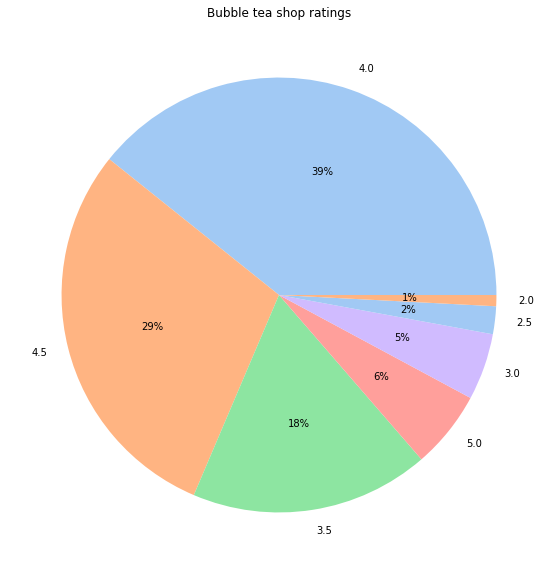

In [45]:
rating_count = df['rating'].value_counts().to_frame().reset_index()
rating_count = rating_count.rename(columns={'index':'rating', 'rating':'count'})
rating_count
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 10))
plt.title('Bubble tea shop ratings')
plt.pie(rating_count['count'], labels = rating_count['rating'], colors = colors, autopct='%.0f%%');

We see that the majority of ratings are either 4 or 4.5 stars with 39% of ratings being 4 stars and 30% of ratings being 4.5 stars. This shows that Bubble tea shops are generally liked by the public but let's also find out which factors may affect these ratings.

#### Distribution of Price

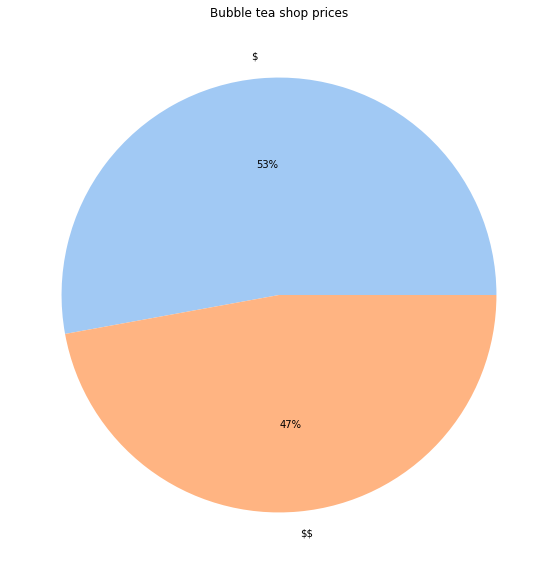

In [46]:
price_count = df['price'].value_counts().reset_index()
price_count = price_count.rename(columns={'index':'name', 'price':'count'})
# price_count
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 10))
plt.title('Bubble tea shop prices')
plt.pie(price_count['count'], labels = price_count['name'].str.replace('\$', '\\$', regex=True), colors = colors, autopct='%.0f%%');

As mentioned before, Yelp uses dollar signs (\$) to categorize approximate cost per person for a meal in a shop. In particular, "\$" means under \$10; "\$\$" means "\$11-\$30"; "\$\$\$" means "\$31-\$60"; and “\$\$\$\$” means "above \$61". 

Bubble tea is a drink so it is expected for prices to be lower in general. Between the two, the price is split pretty evenly between "\$" and "\$\$" with "\$" having a slight edge. Next, we can check if there is a trend between price and the average rating of Bubble tea shops.

<AxesSubplot:title={'center':'Average rating vs. Price of Bubble tea Shop'}, xlabel='Price', ylabel='Rating'>

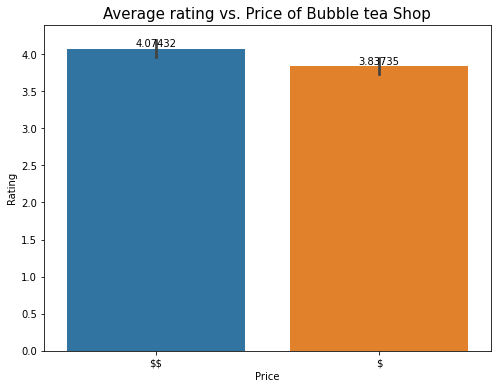

In [47]:
one_cost_df = df[df['price'] == '$']
two_cost_df = df[df['price'] == '$$']

one_cost_avg_rating = one_cost_df['rating'].mean()
two_cost_avg_rating = two_cost_df['rating'].mean()

plt.figure(figsize=(8,6))
plt.title('Average rating vs. Price of Bubble tea Shop', fontsize=15)
ax = sns.barplot(x = df['price'].str.replace('\$', '\\$', regex=True), y = "rating", data=df)
ax.bar_label(ax.containers[0])
plt.xlabel('Price')
plt.ylabel('Rating')
ax

From this barplot we see that more expensive Bubble tea shops have a higher average rating compared to cheaper ones. There could be many reasons for this, such as higher cost shops using better quality ingredients when making their drinks. Another thing we can observe is the review count of Bubble tea shops.

<module 'seaborn' from 'C:\\Users\\Jason\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

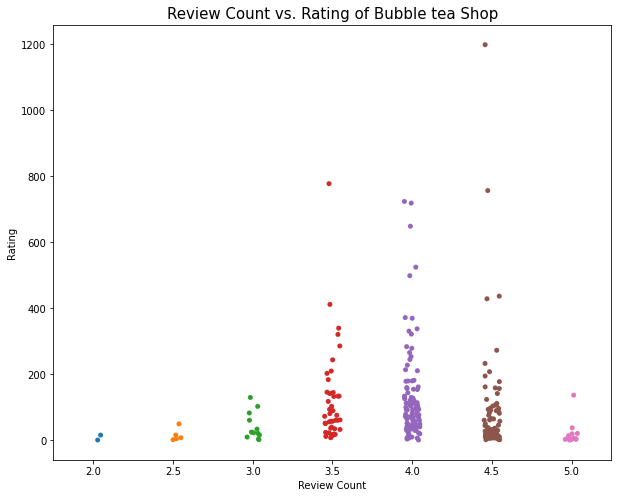

In [48]:
plt.figure(figsize=(10,8))
plt.title('Review Count vs. Rating of Bubble tea Shop', fontsize=15)
sns.stripplot(x = 'rating', y = 'review_count', data=df);
plt.xlabel('Review Count')
plt.ylabel('Rating')
sns

We see that most Bubble tea shops have between 1 to 200 reviews. Some shops with ratings between 3.5 to 4.5 stars have review counts exceeding 200, with the highest reaching 1200 reviews. Generally, the more reviews the more reliable their ratings are as there is a larger sample size from customers. The shop with near 800 reviews but only has a 3.5 star rating suggests that the Bubble tea in that shop is worse than its competitors, while the shop with 1200 reviews but still has an 4.5 stars shows how their Bubble tea is liked by many.

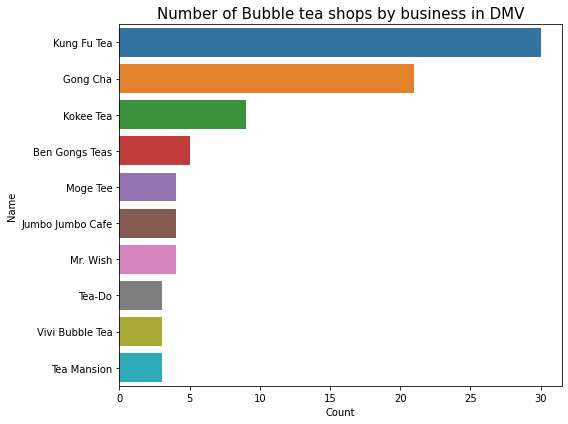

In [49]:
name_counts = df['name'].value_counts().reset_index(drop=False)
name_counts = name_counts.rename(columns={'index':'name', 'name':'count'})
plt.figure(figsize=(8,6))
sns.barplot(x='count',
            y='name', 
            data=name_counts.head(10))
plt.title('Number of Bubble tea shops by business in DMV', fontsize=15)
plt.xlabel('Count')
plt.ylabel('Name')
plt.tight_layout()

The top 3 most common Bubble tea franchise in the DMV is Kung Fu Tea followed by Gong Cha and then Kokee Tea. Kung Fu Tea and Gong Cha leads by a large margin compared to the rest but how do their ratings match up?

Text(0, 0.5, 'Name')

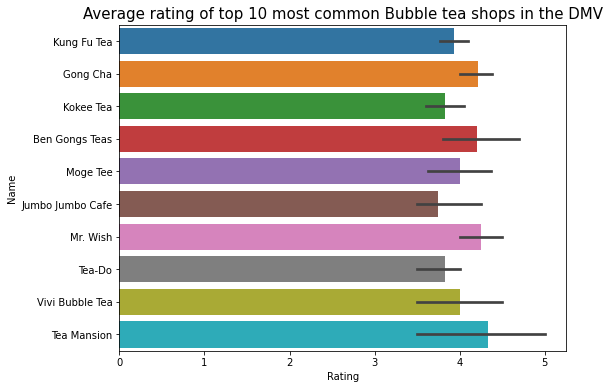

In [50]:
names = name_counts.head(10)['name']
top_count_df = df[df['name'].isin(names)]
plt.figure(figsize=(8,6))
sns.barplot(x=top_count_df['rating'], y=top_count_df['name'], 
            order=list(name_counts.head(10)['name']))
plt.title('Average rating of top 10 most common Bubble tea shops in the DMV', fontsize=15)
plt.xlabel('Rating')
plt.ylabel('Name')

Out of the top 3 Bubble tea franchises, Gong Cha has the best average rating. Gong Cha has an average rating of over 4 while both Kung Fu Tea and Kokee Tea are less than 4. So if you're looking to visit some Bubble tea franchises, you may experience a better Bubble tea at Gong Cha than Kung Fu Tea. Now that we've found out which Bubble tea shop is the most common and which ones are better, we should find out which cities to go to.

<module 'seaborn' from 'C:\\Users\\Jason\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

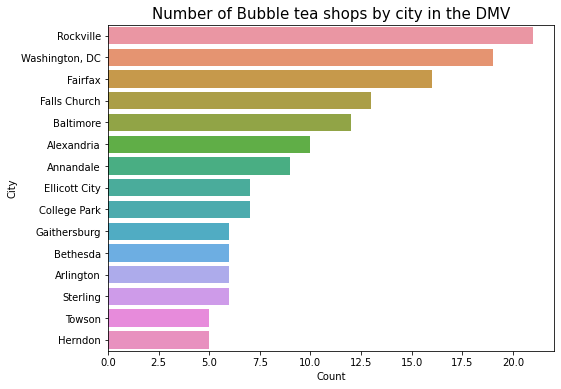

In [51]:
city_count = df['city'].value_counts().reset_index(drop=False)
city_count = city_count.rename(columns={'index':'city', 'city':'count'})

plt.figure(figsize=(8,6))
sns.barplot(x='count', y='city', data=city_count.head(15));
plt.title('Number of Bubble tea shops by city in the DMV', fontsize=15)
plt.xlabel('Count')
plt.ylabel('City')
sns

The cities with the most Bubble tea shops are Rockville, Washington D.C, and Fairfax. This is likely because these cities have a high concentration East Asian population, which are the target consumers. Let's also check for the average ratings of the Bubble tea shops in these cities.

<module 'seaborn' from 'C:\\Users\\Jason\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

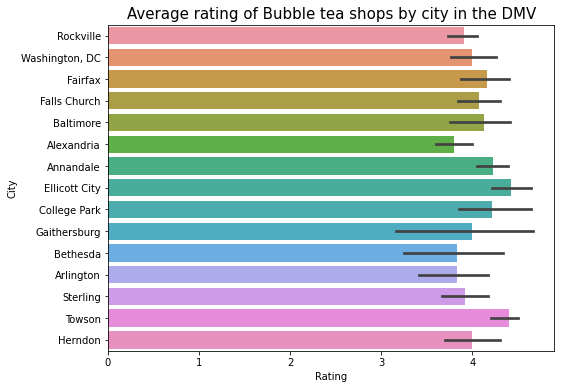

In [52]:
cities = city_count.head(15)['city']
city_count_df = df[df['city'].isin(cities)]
plt.figure(figsize=(8,6))
sns.barplot(x=df['rating'], y=city_count_df['city'], order=list(city_count.head(15)['city']));
plt.title('Average rating of Bubble tea shops by city in the DMV', fontsize=15)
plt.xlabel('Rating')
plt.ylabel('City')
sns

Out of the top 3 cities, Fairfax seems to have a better average rating compared to Rockville and Washington D.C. The highest out of all these cities are Ellicott City and Towson. Despite that, it doesn't mean that cities like Rockville have worse Bubble tea. Rockville has roughly 4 times the amount of Bubble tea shops compared to Ellicott City, so theres a much higher chance in finding a shop that may be worse in comparison. 

Lastly, since we are given coordinates from our dataset, we can plot the shops on a map to visualize them better. The shops are colored by their ratings, with beige markers representing a rating of 5, purple markers representing a rating of 4 and 4.5, blue markers representing shops with a rating of 3 and 3.5 and red markers for ratings of 2.5 and under.

In [53]:
map_osm = folium.Map(location=[38.90, -77.03], zoom_start=10)
for _, shop in df.iterrows():
  if shop['rating'] == 5:
    folium.Marker(location=[shop['latitude'], shop['longitude']],
                icon=folium.Icon(color='beige'), popup=f'{shop["name"]} | {shop["rating"]}*').add_to(map_osm)
  elif shop['rating'] == 4 or shop['rating'] == 4.5 :
    folium.Marker(location=[shop['latitude'], shop['longitude']],
                icon=folium.Icon(color='purple'), popup=f'{shop["name"]} | {shop["rating"]}*').add_to(map_osm)
  elif shop['rating'] == 3 or shop['rating'] == 3.5 :
    folium.Marker(location=[shop['latitude'], shop['longitude']],
                icon=folium.Icon(color='blue'), popup=f'{shop["name"]} | {shop["rating"]}*').add_to(map_osm)
  elif shop['rating'] <= 2.5:
    folium.Marker(location=[shop['latitude'], shop['longitude']],
                icon=folium.Icon(color='red'), popup=f'{shop["name"]} | {shop["rating"]}*').add_to(map_osm)       

map_osm

We can see from the map that most of the Bubble tea shops are concentrated in major cities. We can also easily spot out shops with low ratings and shops with high ratings. Using this map and our analysis from before, we can see where to go for the best Bubble tea within the DMV.

## 5. Conclusion

In this tutorial we analyze several different catgories to see what affects the rating of Bubble tea shops. Based on our analysis, the best places to go for Bubble tea is in a major city with a high asian population and go to the more expensive stores rather than the cheap ones. We also saw that the most common Bubble tea shops around may not always have the best Bubble tea. 

Although we analyzed quite a lot of data, there are still a lot of things left to explore. 

Some ideas for future work and analysis could include:
* Bubble tea Analysis in New York City 
* Predicting Bubble tea shop ratings based on location and price 
* Finding relation between asian population and Bubble tea shops

Having another dataset such as Asian population within the DMV can have some interesting results. Furthermore, better datasets on Bubble tea shops such as having their menu and best selling drinks can also bring more insight. 

I hope that you now have a better understanding of ways to use exploratory data analysis and that you may have a better idea on where to go and which shops to get Bubble tea from!